# CNN Interpretation

Note: This notebook is desinged to run with Python3 and GPU runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_gpu.png)

####[CNI-01]
Import modules and set a random seed.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras import layers
from keras import models
from keras.datasets import mnist

np.random.seed(20190225)

Using TensorFlow backend.


####[CNI-02]
Download the MNIST dataset and store into NumPy arrays.

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

####[CNI-03]
Mount your Google Drive on `/content/gdrive`.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####[CNI-04]
Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.

In [4]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.hd5'

-rw------- 1 root root 38M Feb 25 10:17 '/content/gdrive/My Drive/MNIST_double.hd5'


####[CNI-05]
Restore the model from the exported model file.

In [5]:
model = models.load_model('/content/gdrive/My Drive/MNIST_double.hd5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter1 (Conv2D)        (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv_filter2 (Conv2D)        (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 7, 7, 64)          0         
_______________________________________

####[CNI-07]
Define a function to generate random images that maximize the outputs from filters.

In [0]:
def gen_pattern(layer_output, filter_index=0):
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])

  input_img_data = np.random.normal(0.5, 0.1, 28*28).reshape((1, 28*28))
  for i in range(20):
    loss_val, grads_val = iterate([input_img_data])
    input_img_data += grads_val * 0.1
  
  img = input_img_data[0]
  img -= img.mean()
  img /= (img.std() + 1e-5)
  img = img * 0.1 + 0.5
  img = np.clip(img, 0, 1)
  return img

####[CNI-08]
Generate random images that maximize the outputs from the first filters.

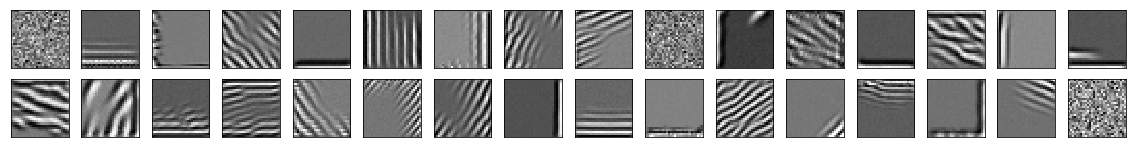

In [7]:
fig = plt.figure(figsize=(20,10))
layer = model.get_layer('conv_filter1').output
for i in range(layer.shape[-1]):
  subplot = fig.add_subplot(8, 16, i+1)
  img = gen_pattern(layer, i)
  subplot.grid(False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(img.reshape(28, 28),
                 cmap=plt.cm.gray_r, interpolation='nearest')

####[CNI-09]
Generate random images that maximize the outputs from the second filters.

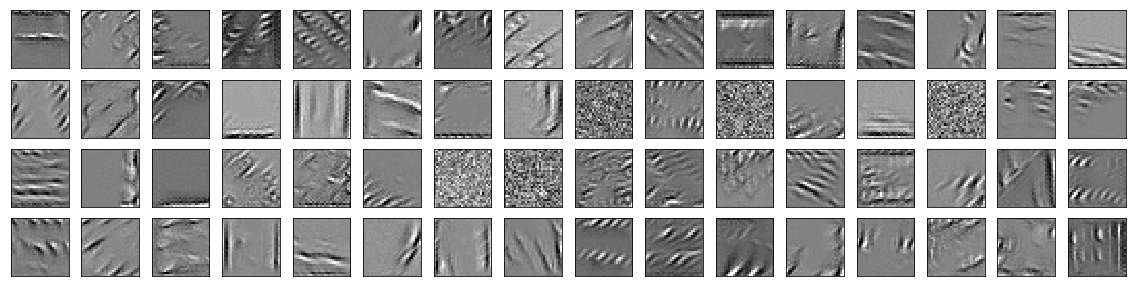

In [8]:
fig = plt.figure(figsize=(20,10))
layer = model.get_layer('conv_filter2').output
for i in range(layer.shape[-1]):
  subplot = fig.add_subplot(8, 16, i+1)
  img = gen_pattern(layer, i)
  subplot.grid(False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(img.reshape(28, 28),
                 cmap=plt.cm.gray_r, interpolation='nearest')

####[CNI-10]
Define a function to detect the sensitive areas in the second filters against the input image, and generate a heatmap.

In [0]:
import cv2
from keras import preprocessing

def get_heatmap(target_image):
  target_image = target_image.reshape(1, 28*28)
  pred = np.argmax(model.predict(target_image))
  pred_output = model.output[:,pred]
  last_conv_layer = model.get_layer('conv_filter2')
  grads = K.gradients(pred_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input],
                       [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_val, conv_layer_output_val = iterate([target_image])

  for i in range(last_conv_layer.output.shape[-1]):
    conv_layer_output_val[:,:,i] *= pooled_grads_val[i]

  heatmap = np.mean(conv_layer_output_val, axis=-1)
  heatmap = np.abs(heatmap)
  heatmap /= np.max(heatmap)

  heatmap2 = np.uint8(255 * cv2.resize(heatmap, (28, 28)))
  heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
  target_image2 = np.uint8(255 * target_image.reshape(28, 28))
  target_image2 = cv2.applyColorMap(target_image2, cv2.COLORMAP_BONE)
  superimposed_img = heatmap2 + target_image2 * 0.6
  cv2.imwrite('/tmp/result.jpg', superimposed_img)

  return heatmap, preprocessing.image.load_img('/tmp/result.jpg')

####[CNI-11]
Show heatmaps for sample images.

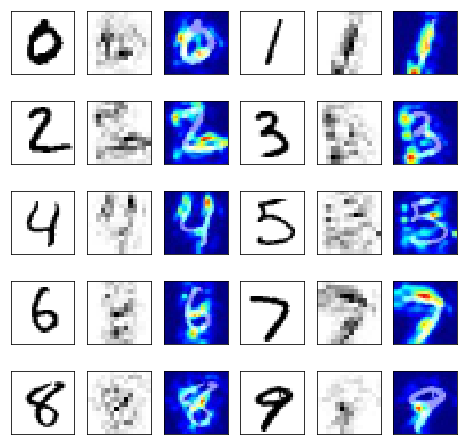

In [18]:
fig = plt.figure(figsize=(8, 8))
i = 1
for img in test_images[[3, 2, 1, 32, 4, 15, 21, 17, 84, 9]]:
  heatmap, superimposed = get_heatmap(img)

  subplot= fig.add_subplot(5, 6, i)
  subplot.grid(False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(img.reshape(28, 28), vmin=0, vmax=1,
                 cmap=plt.cm.gray_r, interpolation='nearest')

  subplot= fig.add_subplot(5, 6, i+1)
  subplot.grid(False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(heatmap, vmin=0, vmax=1,
                 cmap=plt.cm.gray_r, interpolation='nearest')

  subplot= fig.add_subplot(5, 6, i+2)
  subplot.grid(False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(superimposed)
  
  i += 3